# Setup


In [1]:
import os
import pandas as pd
import numpy as np
from Bio.PDB.Chain import Chain
from Bio.PDB.Atom import Atom
from Bio.PDB.Residue import Residue
from Bio.PDB.Structure import Structure
from Bio.PDB.PDBParser import PDBParser
import matplotlib.pyplot as plt
import os
from Bio.PDB import (
    PDBList,
    NeighborSearch,
)
from Bio.PDB.PDBParser import PDBParser
import numpy as np
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from Bio.SeqUtils import seq1
import sys


In [2]:
path = ".."
path_data = path + "/data"
path_figures = path + "/figures/midterm2"

if not os.path.exists(path_data):
    os.mkdir(path_data)
if not os.path.exists(path_figures):
    os.mkdir(path_figures)

# Fetch data


In [3]:
id_protein, id_chain = ['2k5d', 'A' ]
#id_protein, id_chain = ['2lea', 'A' ]

parser = PDBParser(QUIET=True)
pdbl = PDBList()
path_pdb = pdbl.retrieve_pdb_file(id_protein, pdir=path_data + "/pdb", file_format="pdb")
structure = parser.get_structure(id_protein, path_pdb)
new_structure = structure.copy()


structure = parser.get_structure(id_protein, path_pdb)
chain=structure[0][id_chain]
residues = [residue for residue in chain if residue.id[0] == " "]
seq = "".join([seq1(residue.get_resname()) for residue in residues])
print(seq)

Structure exists: '../data/pdb/pdb2k5d.ent' 
MMRLANGIVLDKDTTFGELKFSALRREVRIQNEDGSVSDEIKERTYDLKSKGQGRMIQVSIPASVPLKEFDYNARVELINPIADTVATATYQGADVDWYIKADDIVLTLE


In [4]:
sys.path.append(path_data)
import iupred_data as iu

In [5]:
def get_distance_matrix(atoms, seq_sep=6):
  """
  Calculate a distance matrix considering only 
  CA atoms and a minimum sequence separation.  
  Return a Numpy array
  """
  distances = []
  for atom1 in atoms:
    row = []
    for atom2 in atoms:
      # Check sequence separation
      # if abs(atom1.id[1] - atom2.id[1]) >= seq_sep:
      if abs(atoms.index(atom1) - atoms.index(atom2)) >= seq_sep:
        row.append(atom1 - atom2)
      else:
        row.append(None) # For atoms not respecting sequence separation
    distances.append(row)
  return np.array(distances, dtype=float)

---

# Midterm2

## 1. Contact Map

> Calculate and plot the contact map of your chain. Use the NeighborSearch module and the `search_all(3.5, level=”R”)` method. **Consider only contacts between positions with a sequence separation ≥ 2.**


In [6]:
def get_contact_map(chain: Chain, threshold=3.5, seq_sep=2):
  # Get non het atoms from structure
  atoms = [atom for residue in chain.get_residues() for atom in residue if residue.id[0] == ' ' ]

  
  # Calculate contacts
  ns = NeighborSearch(atoms)

  # Init a empty matrix
  len_residues=len(chain.get_unpacked_list())+1  # residues start from 1, ignoring empty 0
  contact_map_nb = np.zeros((len_residues, len_residues))

  # "search_all" returns the list of atoms in contact based on a distance cutoff
  # level="R" returns pairs of residues instead of atoms
  for residues1, residues2 in ns.search_all(threshold, 'R'):
    if abs(residues1.id[1] - residues2.id[1]) >= seq_sep:
          contact_map_nb[residues1.id[1] , residues2.id[1]] = 1
          contact_map_nb[residues2.id[1], residues1.id[1]] = 1
  contact_map_nb = contact_map_nb[1:, 1:]
  print(sum(contact_map_nb.flatten())/2)
  print(sum(np.triu(contact_map_nb).flatten()))
  return contact_map_nb

286.0
286.0


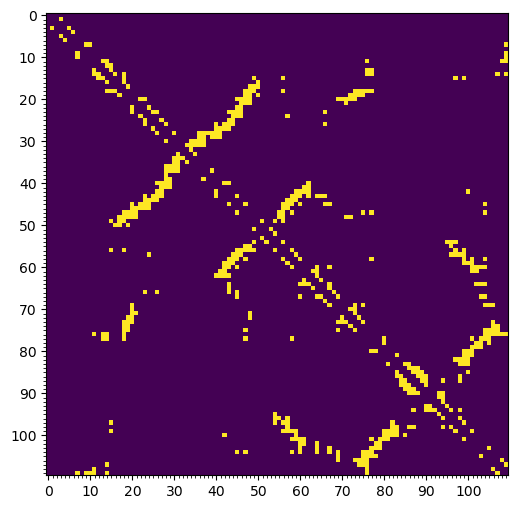

In [7]:
contact_map_nb = get_contact_map(chain, threshold=3.5, seq_sep=2)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map_nb)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path_figures+'/ca_contacts_nb{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

In [8]:
def plot_iupred(pred, pred_smooth, seq, path, pdb_id, chain_id, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("{} {}_{}".format(title, pdb_id, chain_id))
    ax.axhline()
    ax.plot(np.arange(len(seq)), pred, ls='--')
    ax.plot(np.arange(len(seq)), pred_smooth, ls='-')
    
    plt.tight_layout()  # Remove figure padding
    plt.savefig(path + '/iupred_{}_{}.png'.format(pdb_id, chain_id), dpi=300, bbox_inches='tight')


## 2 . Exact Energy

Calculate the exact energy of each residue based on the weighted contribution **of its contacts
(as calculated above)** and plot the raw and smoothed energy for each residue on the same figure.
Use the $M$ matrix to calculate the contact energy

[Iupred_paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5734386/)

> The energy of each residue is calculated by considering the number and types of the **contacting amino acids** and summing the appropriate elements of the statistical potential matrix. $$E^{p}_i=∑^{20}_{j=1}M_{ij}c^{p}_j$$ where
>
> - $E^{p}_i$ energy at position $p$ of type $i$
> - $M_{ij}$ is the interaction energy between amino acid types $i$ and $j$
> - $c^{p}_j$ is the number of interactions of residue at position p with residues of type $j$ in the given conformation.

> Variations in these energies arise depending on the type and number of contacting residues, with hydrophobic residues buried inside the protein core generally exhibiting more favorable energies.


In [9]:
def iupred_exact(seq:list, aa_list: list, m_matrix: list, contact_matrix: list, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param chain: Bio.PDB.Chain
    :param aa_list: list of amino acids
    :param m_matrix: m matrix
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''
    num_contactt=[]
    energy = []  # Calculated energy per sequence position
    energy_smooth = []
    
    seq_indices_type = [aa_list.index(aa) for aa in list(seq)] # Transform sequence into indexes as in the P matrix
    def isContact(i, j):
        return contact_matrix[i][j]==1
    
    for i, aa_index_type in enumerate(seq_indices_type):
        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = 0
        end_before = max(0, i - sequence_separation + 1)
        start_after = min(len(seq_indices_type) - 1, i + sequence_separation)
        end_after = len(seq_indices_type)
        
        indicesWindow = range(0,len(seq_indices_type)) # consider also elements with seqseparation<2 since is non contact in contact matrix
        aaTypeInWindow = seq_indices_type
        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for j,t in zip(indicesWindow, aaTypeInWindow):
            if not isContact(i, j):
                continue
            row[t] += 1

        # calculate AA frequency
        row = row #/ len(indicesWindow)
        num_contactt.append(row)
        # calculate energy
        row = row * m_matrix[aa_index_type ]  
        aa_energy = np.sum(row)
        energy.append(aa_energy)

    # Smooth the energyiction (moving average)
    for i in range(len(energy)):
        frag = energy[max(0, i - window_size_smooth): min(i + window_size_smooth, len(energy))]
        energy_smooth.append(sum(frag) / len(frag))

    return energy, energy_smooth


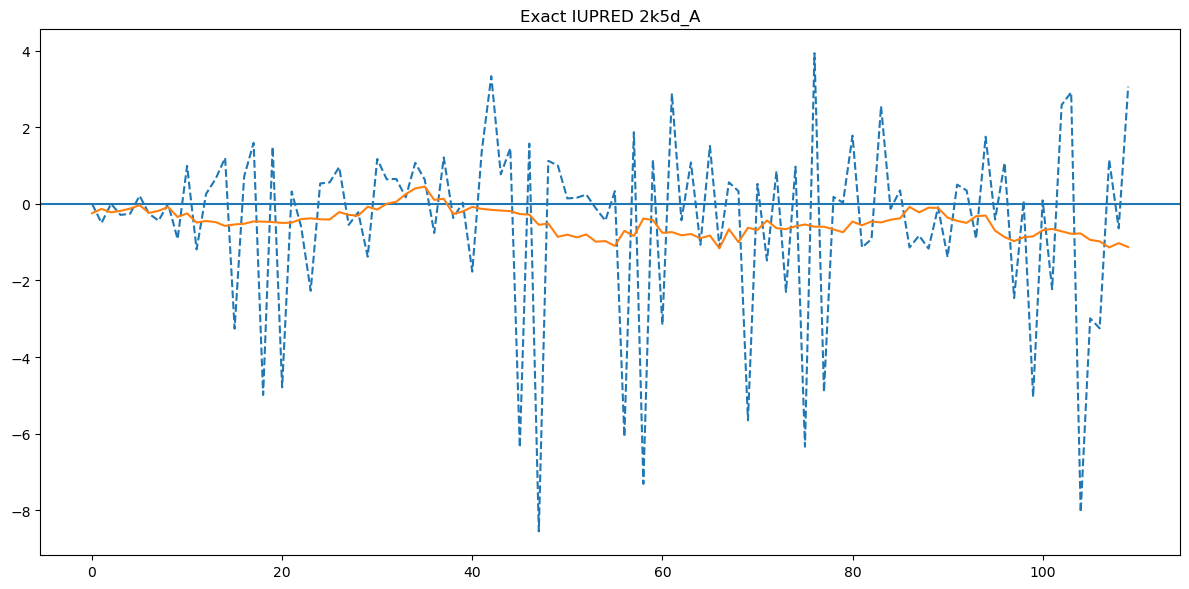

In [10]:
energy, energy_smooth= iupred_exact(seq, iu.aa_list, iu.m_matrix, contact_map_nb, sequence_separation=2, window_size=100, window_size_smooth=10)
plot_iupred(energy, energy_smooth, seq,path_figures, id_protein, id_chain, "Exact IUPRED")


## 3. Estimated Energy

Calculate the estimated energy of each residue based on the weighted contribution of the frequency of neighboring amino acids in the sequence and plot the raw and smoothed energy for each residue on the same figure. Use the P matrix to calculate the estimated energy. **Neighboring residues are those 2-100 residues apart from the current position.**

> A crude approximation was introduced _assuming that energy of a given residue mostly depends on its own type and the types of the amino acids that surround it_.
> The key component of the calculations is the energy estimation matrix, a 20 × 20 matrix that connects the elements of the amino acid composition vector to the energy of a given residue. **The energy of a given residues can be obtained by multiplying the amino acid composition vector elements with the appropriate elements of this energy predictor matrix. $$e^{p}_i=∑^{20}_{j=1}P_{ij}n^{p}_j$$**
> where
>
> - $e^p_i$ is estimated energy at position $p$ of type $i$
> - $P_{ij}$ is the $ij$ element of the energy predictor matrix
> - $n^p_j$ is the $j^{th}$ element of the amino acid composition vector

> **This amino acid composition vector is specific for position p, as it calculated by considering only the local sequential environment within 2–100 residues in either direction.** The choice of this range represents a trade‐off between the intention of covering most structured domains, but separating distinct domains in multidomain proteins.

The matrix elements were optimized using least square fitting, to minimize the difference between energies estimated from the amino acid composition vector and the energies calculated from the known structure for each residue in the dataset of proteins. The correlation between the calculated and estimated energies was surprisingly strong at the level of complete proteins, confirming the validity of this approach.


In [11]:
def iupred_approx(seq:list, aa_list: list, p_matrix: list, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    energy = []  # Calculated energy per sequence position
    energy_smooth = []

    seq_indices_type = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix

    for i, aa_index in enumerate(seq_indices_type):
        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size + 1)
        end_before = max(0, i - sequence_separation + 1)
        start_after = min(len(seq_indices_type) - 1, i + sequence_separation)
        end_after = min(len(seq_indices_type) - 1, i + window_size)
        indices_local = seq_indices_type[start_before: end_before] + seq_indices_type[start_after: end_after]

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1

        # calculate AA frequency
        row = row / len(indices_local)  

        # calculate energy
        row = row * p_matrix[aa_index]  

        aa_energy = np.sum(row)

        energy.append(aa_energy)

    # Smooth the energyiction (moving average)
    for i in range(len(energy)):
        frag = energy[max(0, i - window_size_smooth): min(i + window_size_smooth, len(energy))]
        energy_smooth.append(sum(frag) / len(frag))

    return energy, energy_smooth

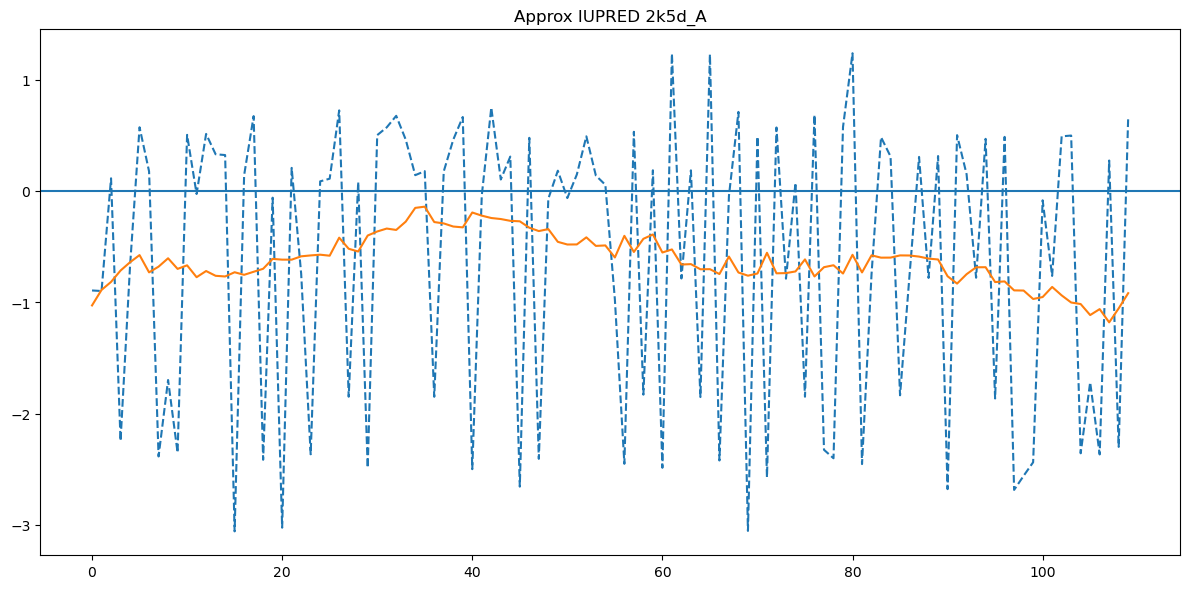

In [12]:
est_energy, est_energy_smooth = iupred_approx(seq, iu.aa_list, iu.p_matrix, sequence_separation=2, window_size=100, window_size_smooth=10)

plot_iupred(est_energy, est_energy_smooth, seq,path_figures, id_protein, id_chain, "Approx IUPRED" )


## 4. Report disorder content

Report the disorder content for the two different calculations. Disorder content can be calculated as the fraction of residues with positive energy (≥ 0) over the length of the sequence. Please report both the fraction and the raw count of residues with positive energy.


In [13]:
names=["energy", "energy_smoothed", "est_energy", "est_energy_smooth"]
energies=[energy, energy_smooth, est_energy, est_energy_smooth]
counts_geq=[len([i for i in e if i >= 0]) for e in energies] 
counts_g=[len([i for i in e if i > 0]) for e in energies] 
fractions_geq=[c/len(seq) for c in counts_geq]
fractions_g=[c/len(seq) for c in counts_g]

df=pd.DataFrame({"count geq":counts_geq, "fraction geq":fractions_geq, "count g":counts_g, "fractions g":fractions_g}, index=names)
#print(df)
print("\n")
df=pd.DataFrame({"count geq":counts_geq, "fraction geq":fractions_geq}, index=names )
print(df)




                   count geq  fraction geq
energy                    60      0.545455
energy_smoothed            7      0.063636
est_energy                56      0.509091
est_energy_smooth          0      0.000000
